# SPAM or HAM

## Implementing a proper Classifier

This notebook builds upon the previous one by:

1. Providing proper text mining processing using NLTK.
2. Implementing a class for the classifier.
3. Employing a trick to improve numerical stability.
3. Evaluating the classifier against a proper SPAM dataset.

### Numerical stability 

Numerical instability is a concept that refers to the propensity of an algorithm or computational
procedure to produce inaccurate results due to round-off errors, truncation errors, or other computational issues.

These errors may be small initially but can accumulate and escalate in the course of iterations, leading to 
results that are significantly far-off from the expected or precise value.

The previous implemenation had to use a reduce to multiple several likelihood probabilities together.

Due to rounding error the program can produce a bad result.

This is where smoothing can help (by providing a small probability to unseen words).

Furthermore, we can explore other operations to reduce the number of multiplications:

$$ \log ab = \log a + \log b $$

$$ \exp \log x = x$$


## Load Libraries

Import NLTK and download the additional data for the tokenizer and lemmatizer.

**Tokenization** is the process of tokenizing or splitting a string, text into a list of tokens.
One can think of token as parts like a word is a token in a sentence, and a sentence is a token in a paragraph.

**Lemmatization** is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. 
Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word.

Examples of lemmatization:

- rocks : rock
- corpora : corpus
- better : good

### POS (Part-of-Speech)

One of the core tasks in Natural Language Processing (NLP) is Parts of Speech (PoS) tagging.
Which is giving each word in a text a grammatical category, such as nouns, verbs, adjectives, and adverbs. 
Through improved comprehension of phrase structure and semantics, this technique makes it possible for machines to study and comprehend human language more accurately.

Lemmatization often involves considering the part of speech (POS) of a word, as the base form may differ based on whether the word is used as a verb, noun, adjective, etc.

Example: The lemma of “went” as a verb is “go,” while as a noun, it remains “went.”

In [1]:
%matplotlib inline
import math
import nltk
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/mantunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mantunes/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mantunes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mantunes/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/mantunes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Toy Dataset

Same dataset, but in a traditional format.

In [2]:
dataset_train = [
('send us your password', 'spam'),
('review our website', 'spam'),
('send your password', 'spam'),
('send us your account', 'spam'),
('Your activity report', 'ham'),
('benefits physical activity', 'ham'),
('the importance vows', 'ham'),
]

dataset_test = [
    ('renew your password', 'spam'),
    ('renew your vows', 'spam'),
    ('benefits of our account', 'ham'),
    ('the importance of physical activity', 'ham')
]

print(f'{dataset_train}')
print(f'{dataset_test}')

[('send us your password', 'spam'), ('review our website', 'spam'), ('send your password', 'spam'), ('send us your account', 'spam'), ('Your activity report', 'ham'), ('benefits physical activity', 'ham'), ('the importance vows', 'ham')]
[('renew your password', 'spam'), ('renew your vows', 'spam'), ('benefits of our account', 'ham'), ('the importance of physical activity', 'ham')]


## Helper Functions

In [3]:
def np_log_fit(x, y):
    a, b = np.polyfit(np.log(x), y, 1)
    return a, b

def np_exp_fit(x, y):
    a, b = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
    return a, np.exp(b)

def plot_vocab(vocab):
    words = [word for word,_ in vocab]
    probs = [prob for _,prob in vocab]
    x_pos = np.arange(len(words)) 

    #slope, intercept = np.polyfit(x_pos, probs, 1)
    #trendline = intercept + (slope * x_pos)

    a, b = np_exp_fit(x_pos, probs)
    trendline_exp = b*np.exp(a*x_pos)

    #plt.plot(x_pos, trendline, color='red', linestyle='--')
    plt.plot(x_pos, trendline_exp, color='green', linestyle='--')
    plt.bar(x_pos, probs,align='center')
    plt.xticks(x_pos, words) 
    plt.ylabel('Probs')
    plt.xticks(rotation=45, ha='right')
    plt.show()

## NB Classifier

In [4]:
class NB:
    def __init__(self, k=1, m=2):
        self.k = k
        self.m = m
        self.lemmatizer = WordNetLemmatizer()
    
    def _nltk_pos_tagger(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif nltk_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:          
            return None
    
    def _nltk_pos_lemmatizer(self, token, tag):
        if tag is None:
            return self.lemmatizer.lemmatize(token)
        else:        
            return self.lemmatizer.lemmatize(token, tag)

    def _vocab(self, samples):
        vocab = [token for sample in samples for token in sample]
        #print(f'{samples}/{vocab}')
        return list(set(vocab))

    def _compute_likelihood(self, samples):
        likelihood = {}
        vocab = self._vocab(samples)
        
        for w in vocab:
            count = 0
            for sentence in samples:
                if w in sentence:
                    #print(w+":", sentence)
                    count += 1
            #print(f"Number of ham emails with the word '{w}': {count}")
            #prob = (count + self.k)/(len(samples) + 2.0*self.k) # smoothing
            #print(f"Probability of the word '{w}': {prob} ")
            likelihood[w.lower()] = count
        return likelihood
    
    def _p_word_spam(self, token):
        return (self.k + self.likelihood_spam.get(token, 0.0)) / ((2.0 * self.k) + self.num_spam_messages)

    def _p_word_ham(self, token):
        return (self.k + self.likelihood_ham.get(token, 0.0)) / ((2.0 * self.k) + self.num_ham_messages)

    def get_spam_vocab(self, n=10):
        vocab = []
        for k in self.likelihood_spam:
            prob = self._p_word_spam(k)
            vocab.append((k, prob))
        # Sort the vocab
        vocab.sort(reverse=True, key=lambda e: (e[1], e[0]))
        # Return
        return vocab[:min(n, len(vocab))]
    
    def get_ham_vocab(self, n=10):
        vocab = []
        for k in self.likelihood_spam:
            prob = self._p_word_ham(k)
            vocab.append((k, prob))
        # Sort the vocab
        vocab.sort(reverse=True, key=lambda e: (e[1], e[0]))
        # Return
        return vocab[:min(n, len(vocab))] 

    def train(self, dataset):
        # compute priors
        dataset_total = len(dataset)
        spam_samples = [txt for txt, label in dataset if label == 'spam']
        ham_samples = [txt for txt, label in dataset if label == 'ham']

        #print(f'{spam_samples}')
        #print(f'{ham_samples}')

        self.ps = len(spam_samples) / dataset_total
        self.ph = len(ham_samples) / dataset_total

        #print(f'{self.ps} {self.ph}')

        # Pre-process text
        ## Tokenize the text and get the POS (Part Of Speech)
        spam_samples_nltk_tagged = [nltk.pos_tag(nltk.word_tokenize(sample)) for sample in spam_samples]
        spam_samples = [[(t[0], self._nltk_pos_tagger(t[1])) for t in tokens] for tokens in spam_samples_nltk_tagged]
        ham_samples_nltk_tagged = [nltk.pos_tag(nltk.word_tokenize(sample)) for sample in ham_samples]
        ham_samples = [[(t[0], self._nltk_pos_tagger(t[1])) for t in tokens] for tokens in ham_samples_nltk_tagged]

        ## Lemmatization with POS
        spam_samples = [[self._nltk_pos_lemmatizer(w,t).lower() for w,t in tokens] for tokens in spam_samples]
        ham_samples = [[self._nltk_pos_lemmatizer(w,t).lower()  for w,t in tokens] for tokens in ham_samples]
        
        ## Filter out small words
        spam_samples = [[w for w in tokens if len(w) > self.m] for tokens in spam_samples]
        ham_samples =  [[w for w in tokens if len(w) > self.m] for tokens in ham_samples]

        #print(f'{spam_samples}')
        #print(f'{ham_samples}')

        # compute_likelihood
        self.likelihood_spam = self._compute_likelihood(spam_samples)
        self.num_spam_messages = len(spam_samples)
        self.likelihood_ham = self._compute_likelihood(ham_samples)
        self.num_ham_messages = len(ham_samples)

        #print(f'{self.likelihood_spam}')
        #print(f'{self.likelihood_ham}')
    
    def predict(self, txt):
        # Pre-process text (similar to the train)
        if txt is not None:
            tokens = nltk.pos_tag(nltk.word_tokenize(txt))
            tokens = [(t[0], self._nltk_pos_tagger(t[1])) for t in tokens]
            tokens = [self._nltk_pos_lemmatizer(w, t).lower() for w,t in tokens]
            tokens = [w for w in tokens if len(w) > self.m]
            #tokens = [self.lemmatizer.lemmatize(w).lower() for w in tokens if len(self.lemmatizer.lemmatize(w)) > 2]
        else:
            tokens = []
        #print(tokens)

        log_p_spam = 0.0
        log_p_ham = 0.0

        for t in tokens:
            log_p_spam += math.log(self._p_word_spam(t))
            log_p_ham += math.log(self._p_word_ham(t))
        
        prob_spam = (math.exp(log_p_spam)*self.ps)/(math.exp(log_p_spam)*self.ps+math.exp(log_p_ham)*self.ph)
        if prob_spam >= 0.5:
            return 'spam', prob_spam
        else:
            return 'ham', prob_spam

In [5]:
clf = NB()
clf.train(dataset_train)

[('your', 0.6666666666666666), ('send', 0.6666666666666666), ('password', 0.5), ('website', 0.3333333333333333), ('review', 0.3333333333333333), ('our', 0.3333333333333333), ('account', 0.3333333333333333)]


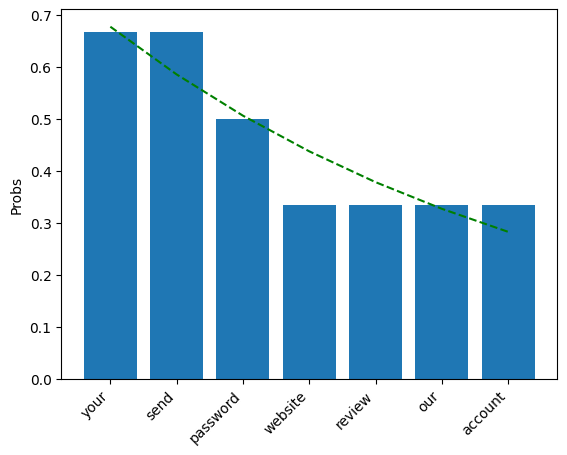

In [6]:
spam_vocab = clf.get_spam_vocab()
print(f'{spam_vocab}')

plot_vocab(spam_vocab)

[('your', 0.4), ('website', 0.2), ('send', 0.2), ('review', 0.2), ('password', 0.2), ('our', 0.2), ('account', 0.2)]


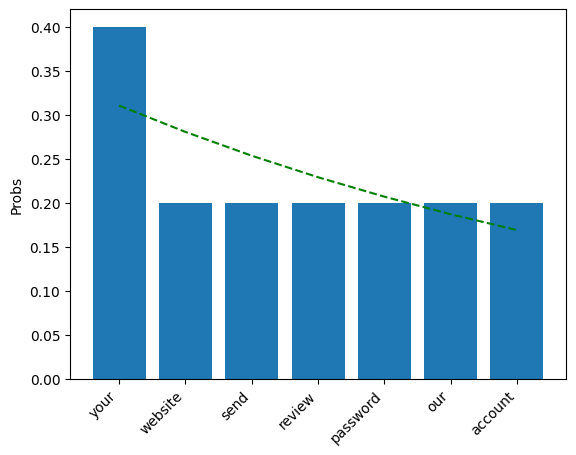

In [7]:
ham_vocab = clf.get_ham_vocab()
print(f'{ham_vocab}')

plot_vocab(ham_vocab)

In [8]:
acc = 0.0
for sentence, label in dataset_train:
    predicted_label, prob_spam = clf.predict(sentence)
    print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_train)}')


send us your password -> spam 0.9487666034155597
review our website -> spam 0.8605851979345954
send your password -> spam 0.9487666034155597
send us your account -> spam 0.9250693802035151
Your activity report -> ham 0.204582651391162
benefits physical activity -> ham 0.06041565973900433
the importance vows -> ham 0.08796622097114705
Accuracy = 1.0


In [9]:
acc = 0.0
for sentence, label in dataset_test:
    predicted_label, prob_spam = clf.predict(sentence)
    print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_test)}')

renew your password -> spam 0.8223684210526315
renew your vows -> ham 0.43554006968641107
benefits of our account -> spam 0.6067961165048542
the importance of physical activity -> ham 0.026092764998121326
Accuracy = 0.5


## Real Dataset

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research.
It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. 

In [10]:
df = pl.read_csv('../../datasets/spam.csv')
df

Target,SMS
str,str
"""ham""","""Go until jurong point, crazy..…"
"""ham""","""Ok lar... Joking wif u oni..."""
"""spam""","""Free entry in 2 a wkly comp to…"
"""ham""","""U dun say so early hor... U c …"
"""ham""","""Nah I don't think he goes to u…"
…,…
"""spam""","""This is the 2nd time we have t…"
"""ham""","""Will �_ b going to esplanade f…"
"""ham""","""Pity, * was in mood for that. …"


In [11]:
dataset = df.rows()
dataset = [(text, label) for (label, text) in dataset]
idx = int(len(dataset)*.8)
dataset_train = dataset[0: idx]
dataset_test = dataset[idx:]

In [12]:
clf = NB()
clf.train(dataset_train)

[('call', 0.43), ('you', 0.32166666666666666), ('your', 0.2833333333333333), ('now', 0.2733333333333333), ('free', 0.225), ('for', 0.225), ('the', 0.22), ('have', 0.21), ('txt', 0.20833333333333334), ('and', 0.165), ('text', 0.16333333333333333), ('from', 0.16166666666666665), ('claim', 0.14666666666666667), ('mobile', 0.14333333333333334), ('win', 0.14166666666666666), ('reply', 0.14), ('with', 0.13833333333333334), ('stop', 0.12), ('prize', 0.11833333333333333), ('get', 0.11833333333333333)]


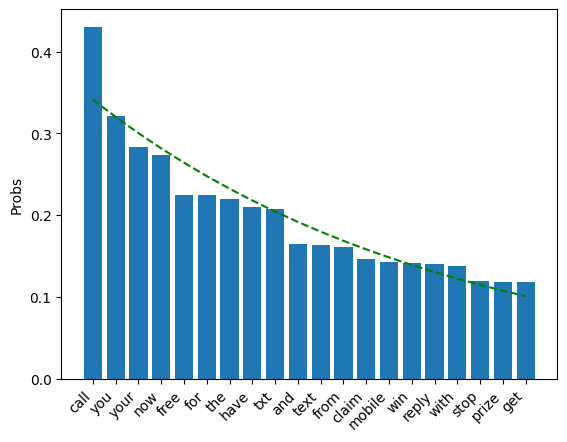

In [13]:
spam_vocab = clf.get_spam_vocab(20)
print(f'{spam_vocab}')

plot_vocab(spam_vocab)

[('you', 0.28534031413612565), ('the', 0.17853403141361257), ('...', 0.14528795811518325), ('and', 0.1450261780104712), ('have', 0.1212041884816754), ('get', 0.112565445026178), ('that', 0.10130890052356022), ('for', 0.09293193717277487), ('but', 0.08376963350785341), ('not', 0.08219895287958115), ('your', 0.07356020942408377), ('can', 0.06963350785340314), ('will', 0.0630890052356021), ('come', 0.0630890052356021), ('how', 0.060209424083769635), ("n't", 0.059947643979057594), ('now', 0.059162303664921465), ('just', 0.059162303664921465), ('when', 0.056282722513089), ('call', 0.05602094240837696), ('what', 0.052094240837696336), ('know', 0.051570680628272254), ('with', 0.049738219895287955), ("'ll", 0.049476439790575914), ('all', 0.04895287958115183), ('this', 0.04869109947643979), ('like', 0.04869109947643979), ('good', 0.04764397905759162), ('then', 0.0468586387434555), ('time', 0.043455497382198956), ('there', 0.04293193717277487), ('want', 0.042408376963350786), ('out', 0.042408376

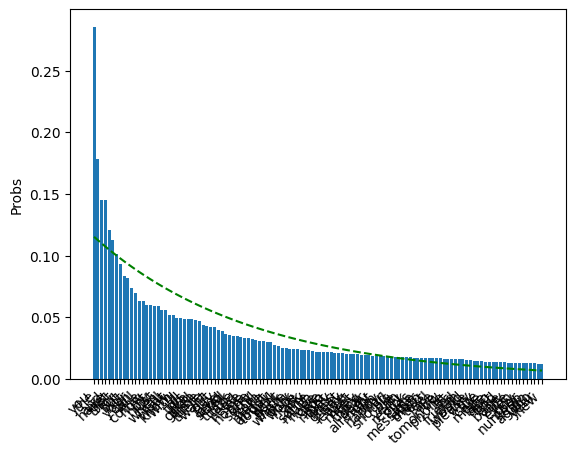

In [14]:
ham_vocab = clf.get_ham_vocab(120)
print(f'{ham_vocab}')

plot_vocab(ham_vocab)

In [15]:
acc = 0.0
for sentence, label in dataset_train:
    predicted_label, prob_spam = clf.predict(sentence)
    #print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_train)}')

Accuracy = 0.827711116142178


In [16]:
acc = 0.0
for sentence, label in dataset_test:
    predicted_label, prob_spam = clf.predict(sentence)
    #print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_test)}')

Accuracy = 0.7502262443438914
